<a href="https://colab.research.google.com/github/bristiHalder/Diagnostic-assistant/blob/main/diagnostic_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!mv '/content/kaggle.json' /root/.config/kaggle/kaggle.json

In [12]:
import os
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile

# Set up Kaggle API
api = KaggleApi()
api.authenticate()

# Define dataset name (Replace with your dataset)
dataset_name = "paultimothymooney/chest-xray-pneumonia"  # Example dataset

# Define paths
download_folder = "dataset"
input_folder = os.path.join(download_folder, "chest_xray", "train")  # Adjust based on dataset structure

# Download dataset
os.makedirs(download_folder, exist_ok=True)
api.dataset_download_files(dataset_name, path=download_folder, unzip=True)

# Define output folders
bacteria_folder = os.path.join(input_folder, "BACTERIAL")
virus_folder = os.path.join(input_folder, "VIRAL")

os.makedirs(bacteria_folder, exist_ok=True)
os.makedirs(virus_folder, exist_ok=True)

# Move files based on names
for filename in os.listdir(input_folder):
    if "bacteria" in filename.lower():
        shutil.move(os.path.join(input_folder, filename), bacteria_folder)
    elif "virus" in filename.lower():
        shutil.move(os.path.join(input_folder, filename), virus_folder)

print("Dataset downloaded and organized successfully!")


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
Dataset downloaded and organized successfully!


In [16]:
!pip install fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.6 MB/s eta 0:00:00
Mounted at /content/gdrive


# ---- FastAI Model Training ----

In [17]:
lung_types = 'NORMAL','VIRUS','BACTERIA'
path = Path('/content/dataset/chest_xray/train')

In [18]:
lungs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms = Resize(128)
)

dls = lungs.dataloaders(path)

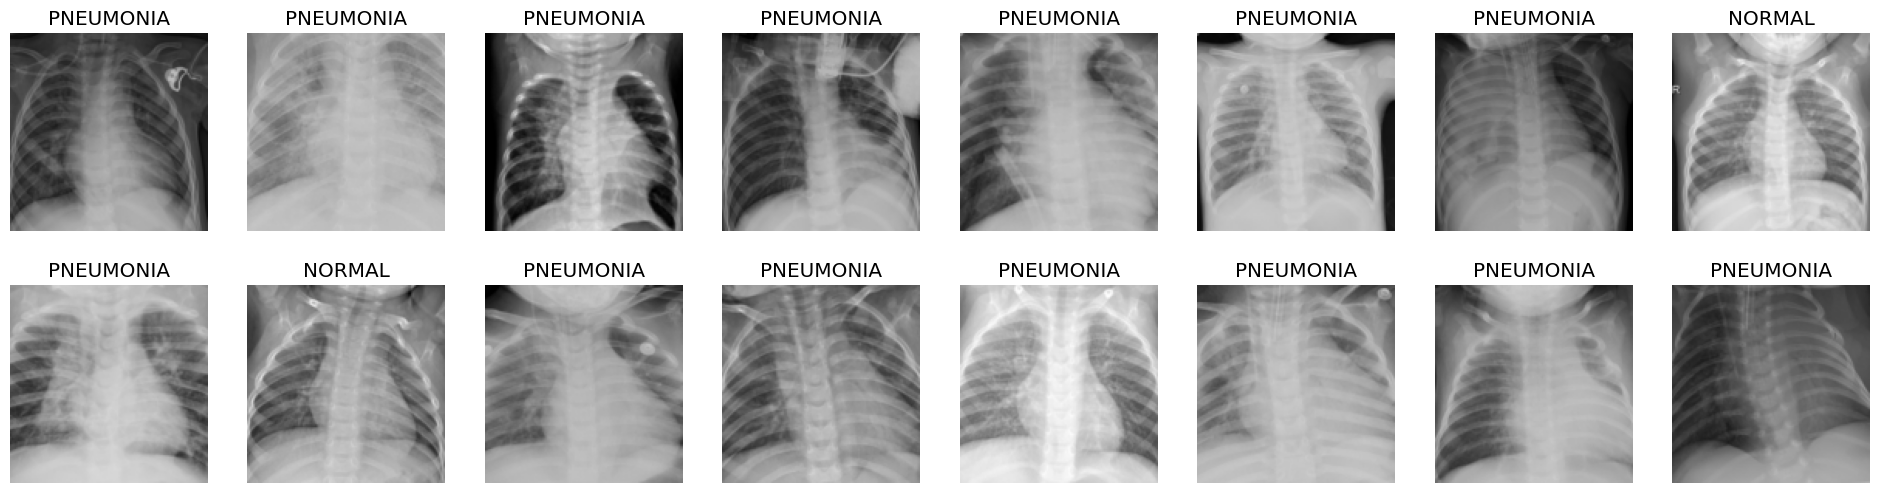

In [19]:
dls.valid.show_batch(max_n=16, nrows=2)

In [21]:
learn = vision_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(6)

epoch,train_loss,valid_loss,accuracy,time
0,0.562933,0.344057,0.911793,08:51


epoch,train_loss,valid_loss,accuracy,time
0,0.209861,0.254519,0.940556,12:13
1,0.182743,0.185104,0.953020,11:54
2,0.123061,0.114948,0.962608,12:05
3,0.076278,0.112868,0.967402,12:07
4,0.052439,0.117733,0.966443,12:08
5,0.044521,0.108040,0.969319,12:08


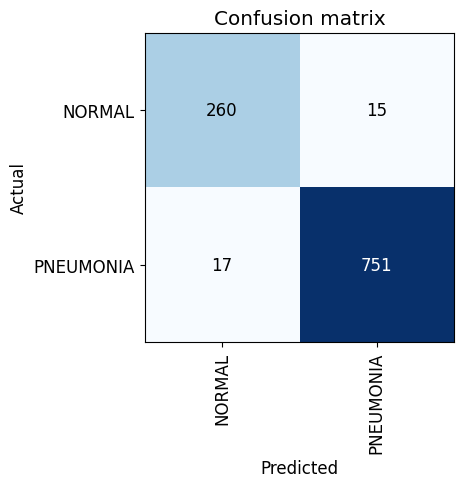

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [23]:
learn.export()

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [25]:
learn_inf = load_learner(path/'export.pkl')

In [26]:
learn_inf.predict('/content/dataset/chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg')

('PNEUMONIA', tensor(1), tensor([0.0086, 0.9914]))

In [29]:
learn_inf.predict('/content/dataset/chest_xray/train/PNEUMONIA/person639_virus_1220.jpeg')

('PNEUMONIA', tensor(1), tensor([3.7621e-04, 9.9962e-01]))

In [31]:
learn_inf.predict('/content/dataset/chest_xray/test/NORMAL/IM-0029-0001.jpeg')

('NORMAL', tensor(0), tensor([9.9996e-01, 3.5740e-05]))

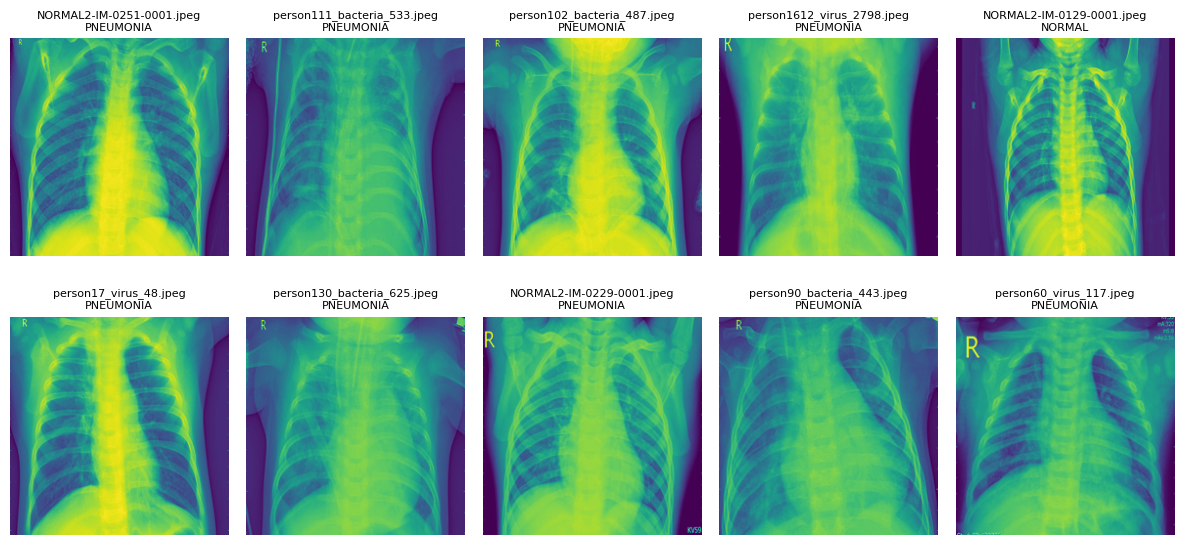

In [32]:
import random
from PIL import Image

# Get the paths to 10 random test images
test_path = Path('/content/dataset/chest_xray/test')
test_images = get_image_files(test_path)
random_images = random.sample(test_images, 10)

# Load the exported learner
learn_inf = load_learner(path/'export.pkl')

# Create a 2x5 table to display the images and their predictions
fig, ax = plt.subplots(2, 5, figsize=(12, 6))

# Loop through the 10 images and show the predicted labels
for i, img_path in enumerate(random_images):
    img = Image.open(img_path)
    img = img.resize((224, 224))
    predicted_label, _, _ = learn_inf.predict(img)

    # Display the image along with the predicted label
    row = i // 5
    col = i % 5
    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(f"{img_path.name}\n{predicted_label}", fontsize=8)

plt.tight_layout()
plt.show()

In [35]:
import gradio as gr
from fastai.vision.all import *
from PIL import Image

In [38]:
import io
learn_inf = load_learner(path/'export.pkl')

def predict_image(img):
    img = PILImage.create(img)  # More robust image handling
    img = img.resize((224, 224)) # Resize for consistency
    pred, pred_idx, probs = learn_inf.predict(img)
    probs_formatted = {learn_inf.dls.vocab[i]: float(probs[i]) for i in range(len(probs))}
    return f"Prediction: {pred}", img, probs_formatted  # Return prediction, image, and probabilities


iface = gr.Interface(
    fn=predict_image,
    inputs=gr.components.Image(type="pil"),  # Use pil type
    outputs=[gr.components.Textbox(label="Predicted Label"),
             gr.components.Image(label="Uploaded Image"),
             gr.components.JSON(label="Probabilities")],
    title="Pneumonia Classification",
    description="Upload an image of a chest x-ray to classify",
    examples=[["/content/dataset/chest_xray/test/NORMAL/IM-0029-0001.jpeg"]] # Example usage
)
iface.launch()



def predict_image(img):
    try:
        img = PILImage.create(img)
        img = img.resize((224, 224))
        pred, pred_idx, probs = learn_inf.predict(img)
        # ... rest of your prediction code
    except Exception as e:
        return f"Error: {e}", None, {}  # Return error message


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e11aeda71c87b9d237.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
